### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.decomposition import PCA

# Preprocessing and feature extracting

The VGG16 model is a convolutional neural network (CNN). It is composed of five main types of layers:
1. **Input Layer:** This is the initial layer of the network where the input image is fed.
2. **Convolutional Layers:** VGG16 consists of multiple convolutional layers, which are the core building blocks of the network. These layers apply a set of filters to the input image, extracting relevant features. The VGG16 architecture uses small 3x3 filters with a stride of 1 and padding to maintain the spatial dimensions of the input.
3. **Pooling Layers:** These layers downsample the output from the convolutional layers to reduce the spatial dimensions. They help to extract the most important features while reducing the computational complexity.
4. **Fully Connected Layers:** After the convolutional and pooling layers, the features are fed into fully connected layers, which perform high-level reasoning and classification. However, these layers are typically removed when using VGG16 for feature extraction.
5. **Output Layer:** This is the final layer of the network, responsible for providing the classification output. In the case of VGG16 trained on ImageNet, this layer outputs a probability distribution over the 1000 classes.

In [2]:
vgg_model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)

In [3]:
CSV_FILE_PATH = "./flower_labels.csv"
df = pd.read_csv(CSV_FILE_PATH)
real_labels = df["label"].to_list()
file_names = df["file"].tolist()

In [ ]:
load_img(file_names[0], target_size=(224, 224))

### Why do we extract features from images?

Feature extraction transforms raw pixel values into a more meaningful information of the image. Using raw pixel values directly can cause problems. each image can have millions of pixels and makes it difficult to apply algorithms effectively. There are noisy pixels (outliers) and feature extracting helps us to detect them.

### Feature extracting methods
1. **Edge detection:** This method identifies and highlights the edges in an image, which can represent important structural information.
2. **Scale-Invariant Feature Transform:** SIFT is a robust and distinctive feature extraction method that identifies key points in an image.
3. **Histogram of Oriented Gradients:** HOG is a feature descriptor used for object detection, primarily in computer vision and image processing. It computes the distribution of gradients and edge directions within an image, which can be used to describe the appearance and shape of objects.

### Preprocessing steps
1. normalizing the pixels by scaling them between zero and one.
2. standardization of images by subtracting them by mean values of ImageNet training data.
3. normalizing the images by dividing them by the sd of the ImageNet training data.

In [4]:
def preprocess_image(img):
    img = np.float32(img) / 255.0 # knowing that each pixel has a positive value less than 256
    return ( img - np.array([0.485, 0.456, 0.406]) ) / np.array([0.229, 0.224, 0.225])

def extract_features(image_path, model):
    img = img_to_array( load_img(image_path, target_size=(224, 224)) )
    img = np.expand_dims(img, axis=0)
    img = preprocess_image(img=img)
    return model.predict(img)


extracted_features = []
for file_name in file_names:
    extracted_features.append(extract_features(image_path='./flower_images/' + file_name, model=model))
    print(f"Processing {int(file_name[:4])}'th image", end="\r", flush=True)

extracted_features = np.array(extracted_features)
features = extracted_features.reshape(210, -1)

1/1 [==============================] - 1s 644ms/step


# Clustering

**K-Means:** It is an unsupervised machine learning algorithm used for clustering. There is only one hyperparameter and that is *k*, the number of clusters. First of all it picks *k* distinct points from the data. Then it groups the rest of the points based on their euclidian distance from those *k* points. Now for each cluster it calculates the mean of all points in it and repeat the clustering process again with new *k* points. After a few iterations the clustering won't change anymore and that is the final answer. Also k-means doesn't identify any point as noise (based).

**DBSCAN:** DBSCAN is a density-based clustering algorithm designed to identify clusters of arbitrary shapes in a dataset. Let's describe the algorithm. There are two hyperparameters. *R* which is the radious of adjacency circle and *N* which is the minimum number of adjacents for each point to be count as a core point. First of all it identifies core points by simply drawing a circle around each point and count the number of points in it. After that it randomly selects a core point and starts to form a new cluster based on the core point. It adds all the close core points to the cluster. Then all the core points close to them and so on. When there is no more core points to add, It adds all the non-core points which was close to the core points to the cluster. It repeats the same process to identify the rest of the clusters as well. At the end there might be some unmarked points and those are the noisy points.

**Comparison of two algorithms:** K-means is more efficient for large datasets and is simpler to understand and implement. unlike k-means, DBSCAN is not sensitive to outliers. Unlike K-Means, DBSCAN does not assume clusters to be spherical and can discover clusters with varying shapes and sizes

# Dimension Reduction
### What is PCA?
Principal Component Analysis is a dimensionality reduction technique used in machine learning. Its primary purpose is to transform high-dimensional data into a lower-dimensional representation while maintaining the most important information. This is particularly useful when dealing with datasets with a large number of features like our dataset here. There are some dimensions with low-price information for us. It means that the values in it is about the same for all the images of our dataset and removing it wouldn't hurt much. If i want to explain how PCA works in a simpler way, Imagine you have a box of many different buttons. There are so many of them, and it's hard to tell what's in the box just by looking at it. PCA is like sorting these buttons by their main features to make it easier to understand what's in the box.

In [5]:
def reduce_dimensions(n, features):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(features)
    return reduced_features

f = {n: reduce_dimensions(n=n, features=features) for n in [2, 3]}

## Finding optimal *k* to use in k-means algorithm
There are different methods to find the best k. Here i used elbow method, silhouette and homogeneity score. Elbow method calculates the sum of squared distances between data points and their nearest cluster centroid, known as the Within-Cluster Sum-of-Squares (WCSS) for different k values. I'll explain two other methods later.

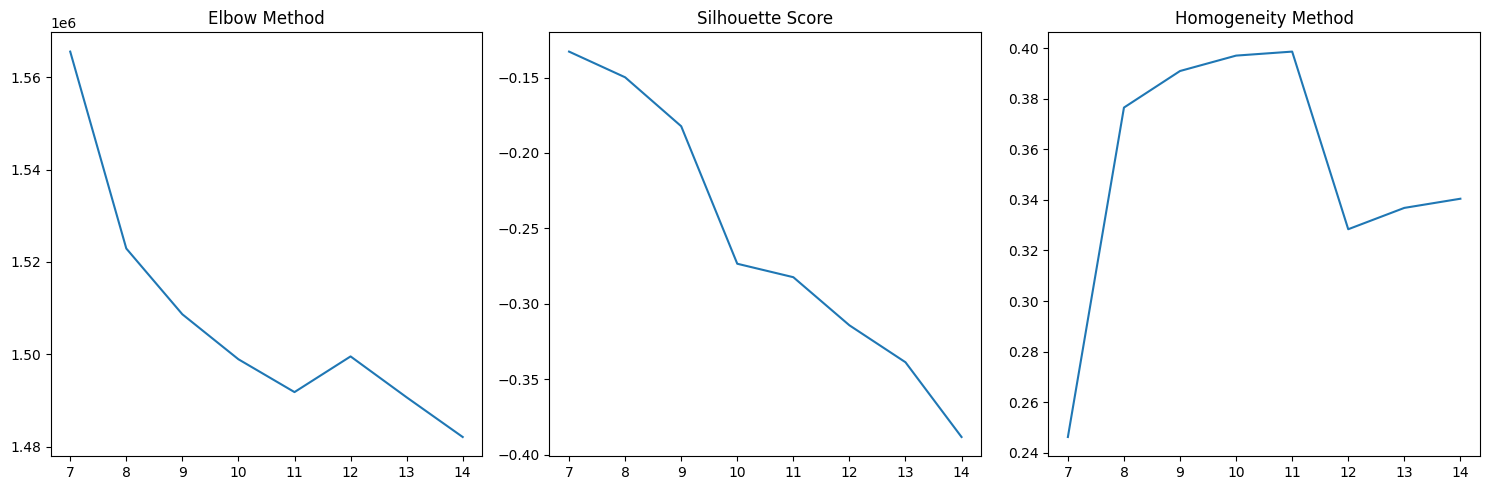

In [6]:
def calc_silhouette_score(features, predicted_labels):
    return silhouette_score(X=features, labels=predicted_labels)

def calc_homogeneity_score(real_labels, predicted_labels):
    return homogeneity_score(labels_true=real_labels, labels_pred=predicted_labels)

def run_tests_to_find_optimal_k(rng, f):
    inertia = []
    silhouette_scores = []
    homogeneity_scores = []
    for k in rng:
        kmeans_model = KMeans(n_clusters=k, random_state=17)
        kmeans_model.fit(X=features)
        pred_labels = kmeans_model.labels_

        inertia.append(kmeans_model.inertia_)

        silhouette_scores.append(calc_silhouette_score(f, pred_labels))

        homogeneity_scores.append(calc_homogeneity_score(real_labels, pred_labels))

    return [inertia, silhouette_scores, homogeneity_scores]

def draw_graph_k(rng, scores):
    titles = ["Elbow Method", "Silhouette Score", "Homogeneity Method"]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    for i in range(3):
        axes[i].set_title(titles[i])
        axes[i].plot(rng, scores[i])
    plt.tight_layout()
    plt.show()

rng = range(7, 15)
scores = run_tests_to_find_optimal_k(rng=rng, f=f[2])    
draw_graph_k(rng=rng, scores=scores)

Let's analyse the graphs. Obviously the higher the number of clusters is, the less the WCSS gets. But we don't want that. what we want is a reasonable number of clusters with both good accuracy and efficiency. Any number greater than or equal to 10 seems good. Silhouette doesn't seem very reliable and we have to refer to homogeneity score. Homogeneity score suggests that any number in range of 8 to 10 is suitable. In conclusion *k=10* seems accurate enough.

## Training models

In [7]:
def train_k_mean_model(k, features):
    kmeans_model = KMeans(n_clusters=k, random_state=17)
    kmeans_model.fit(X=features)
    labels = kmeans_model.labels_
    return kmeans_model, labels

def train_DBSCAN_model(r, n, features):
    dbscan_model = DBSCAN(eps=r, min_samples=n)
    dbscan_model.fit(X=features)
    labels = dbscan_model.labels_
    return dbscan_model, labels

k = 12
r = {2: 7, 3: 17}
n = {2: 2, 3: 3}
labels_k, labels_db = dict(), dict()
kmean_model, dbscan_model = dict(), dict()
for dim in [2, 3]:
    kmean_model[dim], labels_k[dim] = train_k_mean_model(k=k, features=f[dim])
    dbscan_model[dim], labels_db[dim] = train_DBSCAN_model(r=r[dim], n=n[dim], features=f[dim])

# Visualazing clusters

In [8]:
def draw_scatter_plot_2D(titles, rngs, features, pred_labels):
    labels_df = pd.DataFrame({'label': real_labels, titles[0]: pred_labels[0], titles[1]: pred_labels[1]})
    
    labels_df['PCA1'] = features[:, 0]
    labels_df['PCA2'] = features[:, 1]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    for i in range(2):
        for cluster in (rngs[i]):
            cluster_data = labels_df[labels_df[titles[i]] == cluster]
            ax[i].scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'cluster {cluster}')
        ax[i].set_title(titles[i])
        ax[i].legend()
    plt.tight_layout()
    plt.show()

def draw_scatter_plot_3D(title, pred_label, features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=pred_label, cmap='viridis')
    ax.set_title(title)
    plt.show()

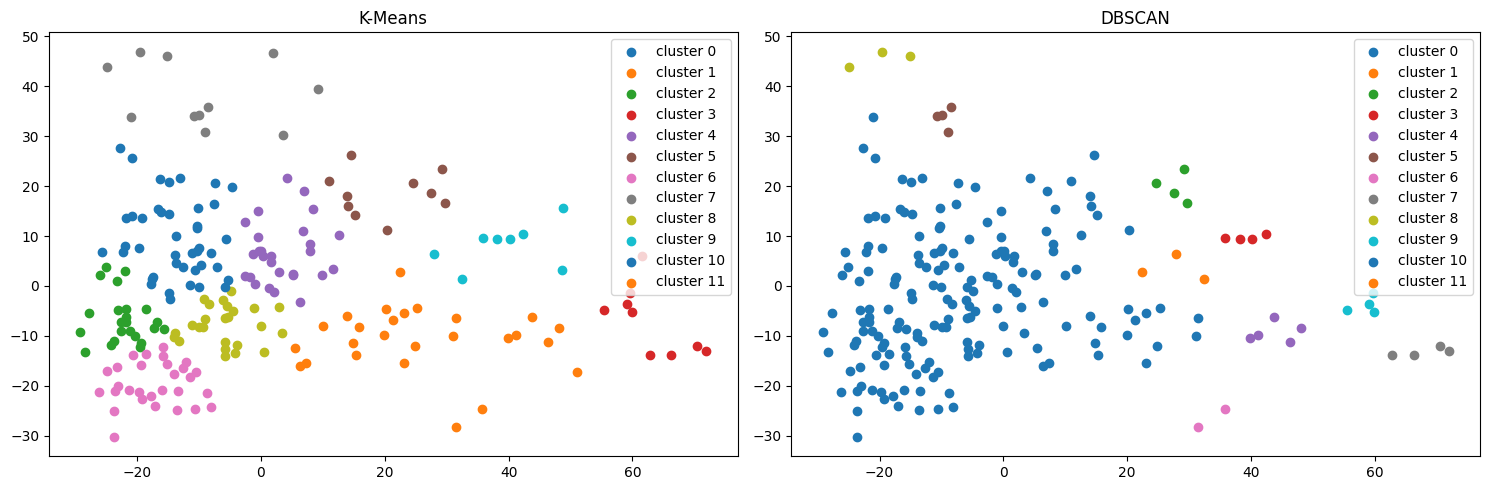

In [9]:
draw_scatter_plot_2D(titles=["K-Means", "DBSCAN"], rngs=[range(k), range(k)],
                     features=f[2], pred_labels=[labels_k[2], labels_db[2]])

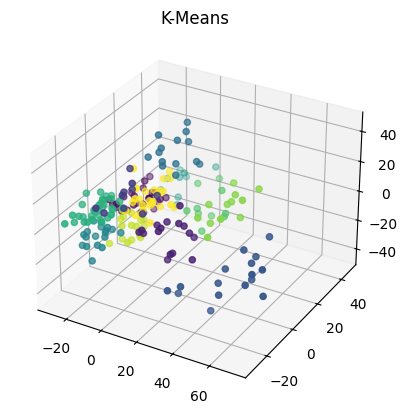

In [10]:
draw_scatter_plot_3D(title="K-Means", pred_label=labels_k[3], features=f[3])

In [11]:
def cluster(labels, file_names, k):
    # the extra cluster is for noisy points. the clustering model labels noisy points as -1.
    clusters = [ [] for _ in range(k+1) ] 
    for i in range(len(labels)):
        clusters[labels[i]].append(file_names[i])
    return clusters

def show_cluster(file_names):
    plt.figure(figsize = (25, 25))
    ind = 0
    for file_name in file_names:
        ind += 1
        plt.subplot(15, 15, ind)
        img = load_img("./flower_images/" + file_name)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

def show_clusters(labels, k):
    clusters = cluster(labels=labels, file_names=file_names, k=k)
    for c in clusters:
        show_cluster(c)

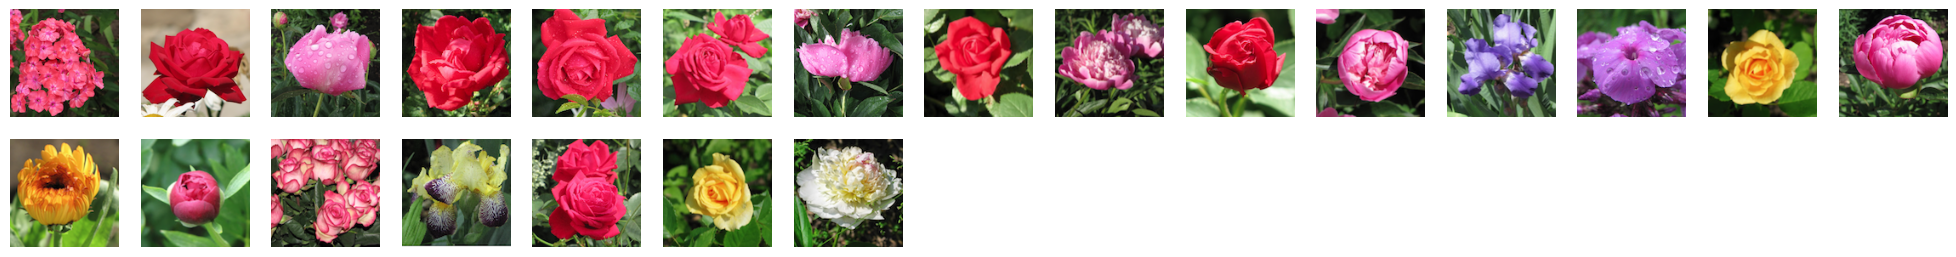

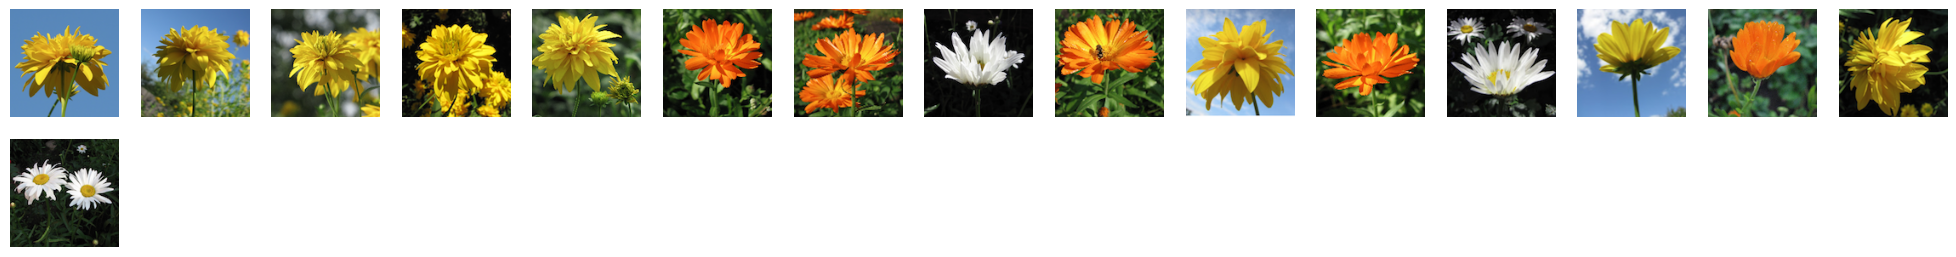

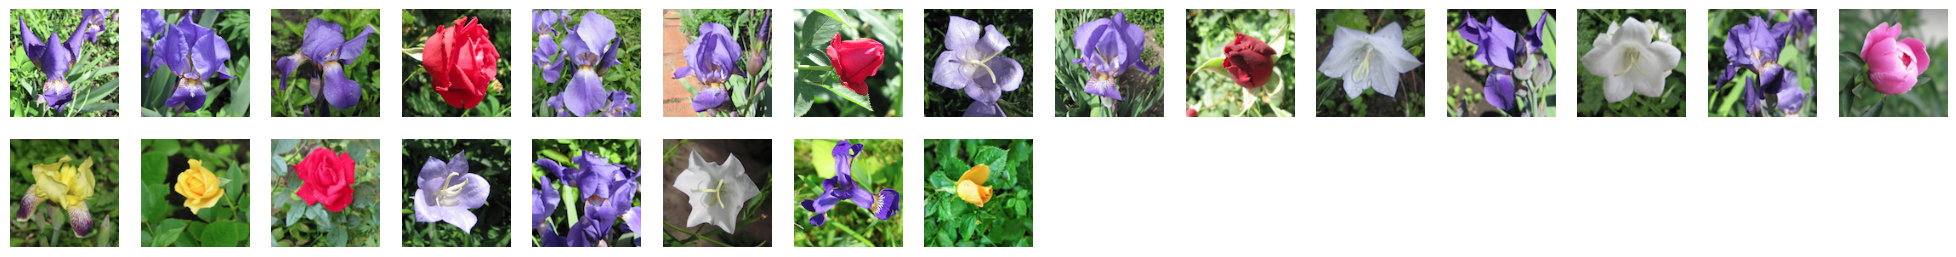

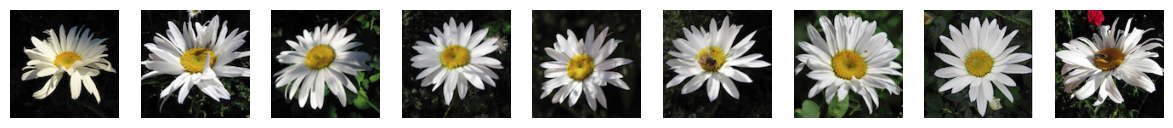

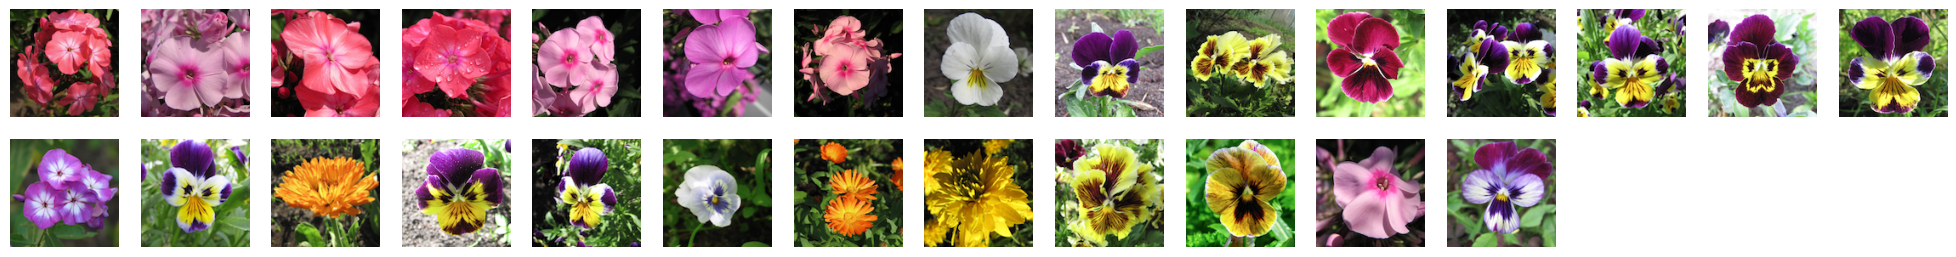

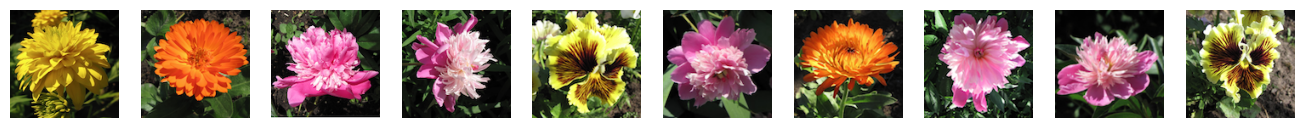

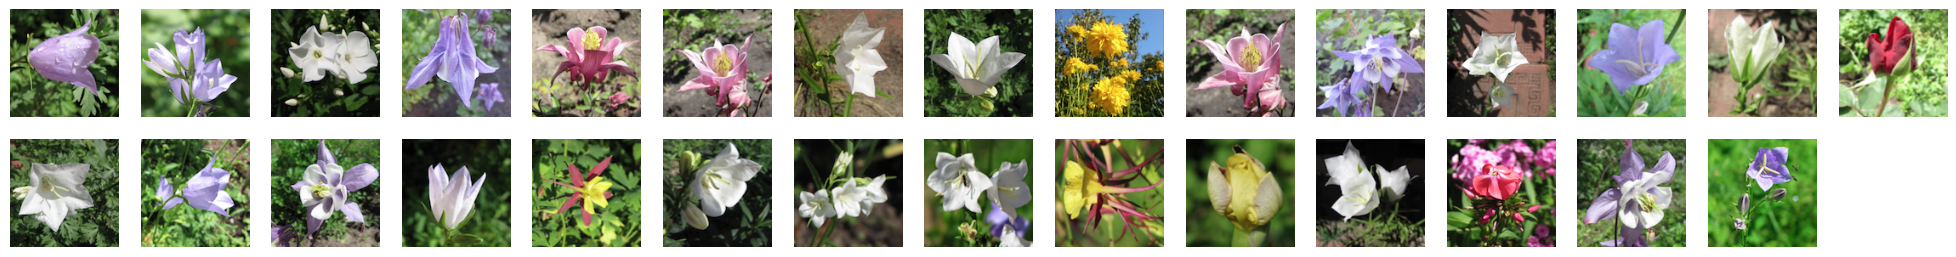

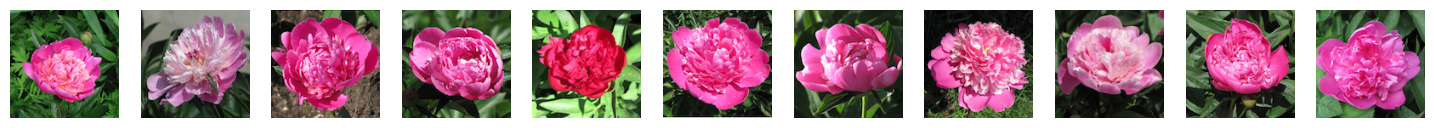

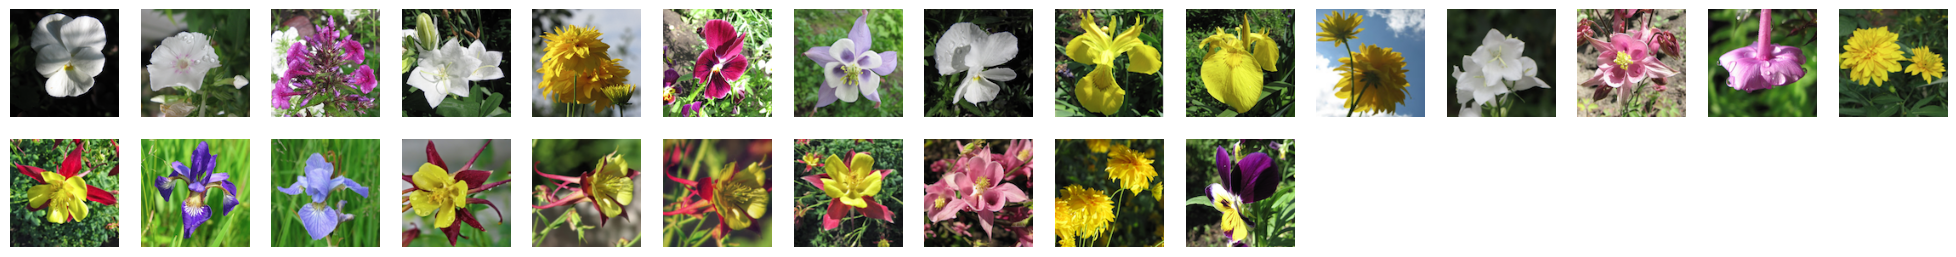

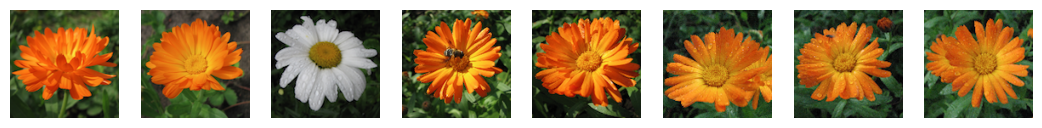

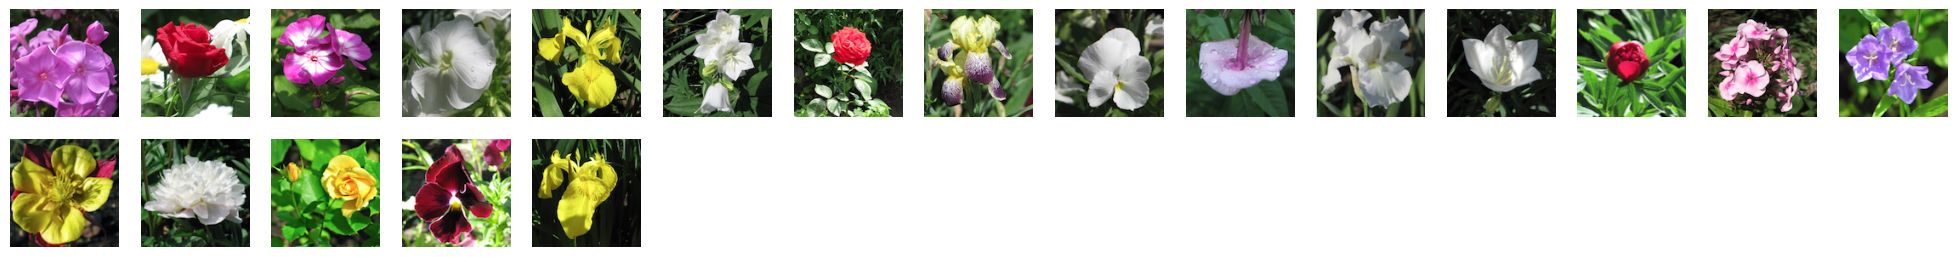

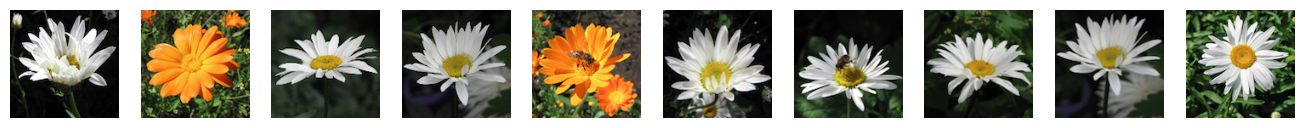

<Figure size 2500x2500 with 0 Axes>

In [12]:
show_clusters(labels_k[2], k=k)

# Evaluation & Analysis
## Silhouette score
It is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The Silhouette Score is the mean Silhouette Coefficient for all samples. Silhouette coefficient is calculated as follows:
where s is the cluster the point is in and c is the nearest cluster to the point other than its own cluster. The silhouetter score is assigned to the mean of all coefficients.

$ A_i = \frac{1}{N_s} \times \sum_{j=1}^{N_s} {dis(P_i, P_j)} $

$ B_i = \frac{1}{N_c} \times \sum_{j=1}^{N_c} {dis(P_i, P_j)} $

$ S_i = \frac {B_i - A_i} {max(A_i, B_i)} $


$ \text{Silhouette Score} = \frac{1}{K} \sum_{c=1}^{K} \frac{1}{N_c} \times \sum_{i=1}^{N_c} {S_i} $

## Homogeneity Score
It measures the extent to which each cluster contains only data points that are similar to each other. It ranges from 0 to 1, with a higher value indicating better clustering results. The logic behind the homogeneity score is to compare the actual cluster assignments with the class labels of the data points.
Where N is the total number of data points in the dataset and M is the sum of the minimum number of data points in each cluster that belong to the most frequent class in that cluster.

$\text{Homogeneity Score} = \frac{N - M}{N - \min(N, M)}$


In [13]:
def show_result(k, db, f):
    result = []
    for i in [2, 3]:
        result.append({ "Silhouette K-Mean": calc_silhouette_score(f[i], k[i]),
                    "Homogeneity K-Mean": calc_homogeneity_score(real_labels, k[i]),
                    "Silhouette DBscan": calc_silhouette_score(f[i], db[i]),
                    "Homogeneity DBscan": calc_homogeneity_score(real_labels, db[i]) })

    return pd.DataFrame(result, index=[f"{2} Dim", f"{3} Dim"])
    
show_result(k=labels_k, db=labels_db, f=f)

Silhouette K-Mean  Homogeneity K-Mean  Silhouette DBscan  \
2 Dim           0.353975            0.512309           0.229528   
3 Dim           0.299438            0.503972           0.395899   

       Homogeneity DBscan  
2 Dim            0.177694  
3 Dim            0.079109

I'm not sure why, but the scores weren't as high as I expected. Despite this, the scatter plots visually indicated reasonably accurate clustering.


## How to Improve Clustering Result?
1. **Preprocessing:** I performed some simple data preprocessing techniques. With more advanced and precise preprocessing methods, we could have achieved a more accurate model.
2. **Feature Extraction:** Other techniques beside PCA might be available for extracting more valuable features. However, PCA performed adequately in our task.
3. **Algorithm Modification:** There exists enhanced versions of K-Means and DBscan. For instance, an improved DBSCAN algorithm called K-DBSCAN applies an initial grouping to the data through the K-means++ algorithm, then employs DBSCAN to perform clustering in each group separately.
4. **Dataset:** A larger dataset could lead to better models, as more data usually contributes to improved accuracy.
5. **Hyperparameters:** There is an optimal value for each hyperparameter. Although I experimented with various values and obtained reasonable results, it is possible that more fine-tuning could yield even better outcomes.